In [1]:
import scipy.io
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from pykrige.ok import OrdinaryKriging

In [2]:
mat_data = scipy.io.loadmat('../data/InSAR_vertical_wholeCV_downsample500mx500m.mat')

DZ = mat_data['DZ'].flatten()
Z = mat_data['Z'].flatten()
lnx = mat_data['lnx'].flatten()
lty = mat_data['lty'].flatten()

df = pd.DataFrame({
    'Longitude': lnx,
    'Latitude': lty,
    'Z': Z,
    'DZ': DZ
})

In [3]:
df

,Longitude,Latitude,Z,DZ
0,-122.541102,39.859374,0.566691,0.069111
1,-122.540790,39.863396,0.776471,0.064225
2,-122.536195,39.855112,0.510672,0.061217
3,-122.535884,39.859134,0.194299,0.078462
4,-122.535572,39.863156,0.520263,0.056262
...,...,...,...,...
265323,-118.606756,35.283054,0.542738,0.101017
265324,-118.606143,35.286905,0.641504,0.082334
265325,-118.605529,35.290757,0.753156,0.089112
265326,-118.604915,35.294608,0.603030,0.098666


In [4]:
len(df.Longitude.unique())

265328

In [5]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

In [6]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # WGS84

# Step 2: Reproject gdf to match gdf_points (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

# Step 3: Perform a spatial join
gdf_joined = gpd.sjoin(gdf_points, gdf, how="left", predicate="within")

# Step 4: Add the Basin_Subb column to df
df['Basin_Subb'] = gdf_joined['Basin_Subb']

# Step 5: Handle points outside any polygon
df['Basin_Subb'] = df['Basin_Subb'].fillna('Unknown')

In [7]:
sar_5021 = df[df.Basin_Subb.str.startswith("5-021")].copy()

In [8]:
sar_5021

,Longitude,Latitude,Z,DZ,Basin_Subb
0,-122.541102,39.859374,0.566691,0.069111,5-021.51
1,-122.540790,39.863396,0.776471,0.064225,5-021.51
3,-122.535884,39.859134,0.194299,0.078462,5-021.51
4,-122.535572,39.863156,0.520263,0.056262,5-021.51
5,-122.535260,39.867177,0.692786,0.064696,5-021.51
...,...,...,...,...,...
93230,-121.093266,38.495754,1.660928,0.148348,5-021.65
93231,-121.092835,38.499727,1.556699,0.124319,5-021.65
93232,-121.092404,38.503700,1.604036,0.126796,5-021.65
93233,-121.091973,38.507673,1.515466,0.118812,5-021.65


/var/folders/cm/7q16kyx93zs34t0y4j49dt000000gn/T/ipykernel_1910/2100264459.py:146: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


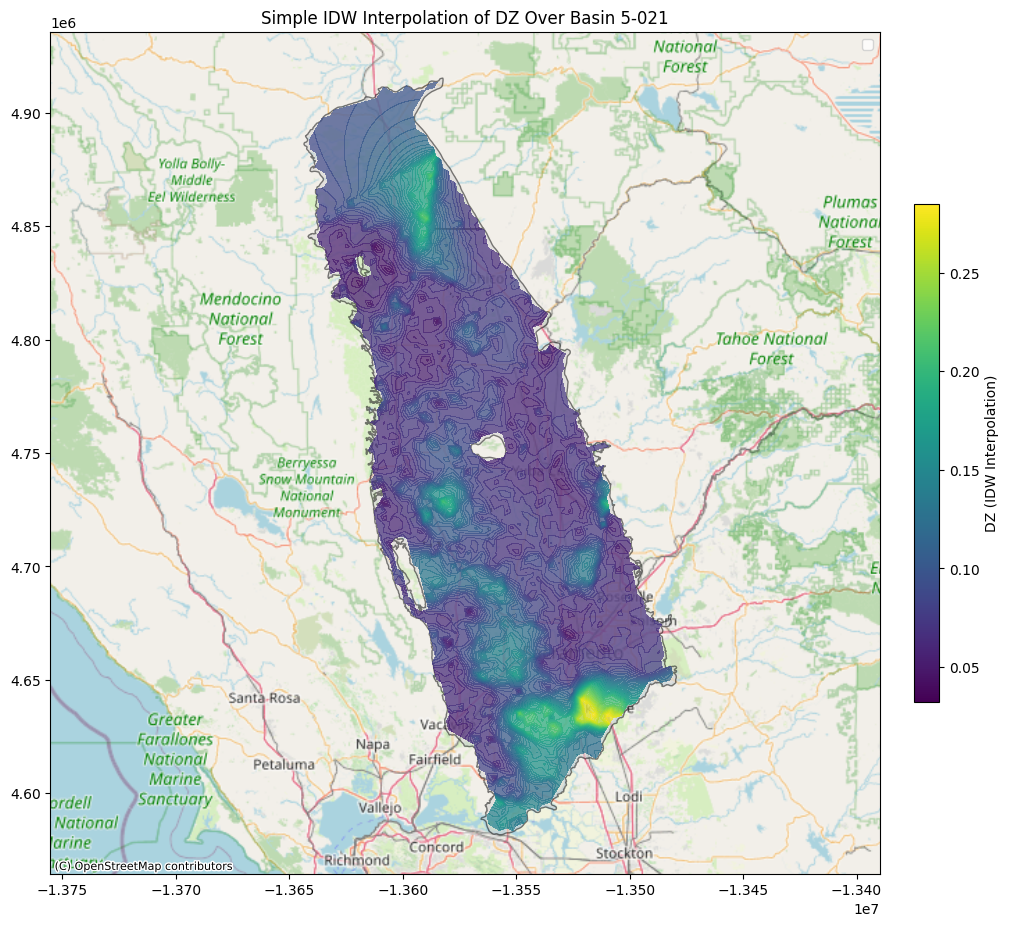

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from pyproj import Transformer
import matplotlib as mpl

# ------------------------------------------------------------------------------
# 1. Filter the Polygons and Make One Large Shape
# ------------------------------------------------------------------------------
# gdf is your GeoDataFrame of polygons
# We only want shapes where gdf['Basin_Numb'] == '5-021'
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']

# Dissolve into a single polygon
merged_polygon = filtered_gdf.dissolve().geometry.iloc[0]

# Create a new GeoDataFrame with that single merged polygon
poly_gdf = gpd.GeoDataFrame(geometry=[merged_polygon], crs=filtered_gdf.crs)

# Reproject polygon to a projected CRS (e.g., EPSG:32633) for distance calculations
poly_gdf_32633 = poly_gdf.to_crs(epsg=32633)
bounds = poly_gdf_32633.total_bounds  # [minx, miny, maxx, maxy]

# ------------------------------------------------------------------------------
# 2. Prepare the Points (sar_5021)
# ------------------------------------------------------------------------------
# sar_5021 has columns: 'Latitude', 'Longitude', 'DZ'
points_gdf = gpd.GeoDataFrame(
    sar_5021,
    geometry=gpd.points_from_xy(
        sar_5021['Longitude'], 
        sar_5021['Latitude']
    ),
    crs="EPSG:4326"
)

# Reproject points to match polygon (EPSG:32633)
points_gdf_32633 = points_gdf.to_crs(epsg=32633)

# Extract coordinate arrays and the DZ values
x = points_gdf_32633.geometry.x.values
y = points_gdf_32633.geometry.y.values
z = points_gdf_32633['DZ'].values  # your "DZ" column

# ------------------------------------------------------------------------------
# 3. Generate a Grid & Define a Simple IDW Function
# ------------------------------------------------------------------------------
num_cells = 100  # adjust resolution as needed
grid_x = np.linspace(bounds[0], bounds[2], num=num_cells)
grid_y = np.linspace(bounds[1], bounds[3], num=num_cells)

xx, yy = np.meshgrid(grid_x, grid_y)

def idw(x_coords, y_coords, values, xi, yi, power=2.0):
    """
    Naive IDW interpolation.
    x_coords, y_coords, values: arrays of your data points
    xi, yi: coordinates where you want to interpolate (1D or 2D arrays)
    power: IDW power parameter (2 is typical)

    Returns: array of interpolated values matching shape of xi, yi.
    """
    # Flatten xi, yi if they are 2D (for easier looping)
    xi_flat = xi.ravel()
    yi_flat = yi.ravel()

    # Initialize output
    interpolated = np.empty_like(xi_flat, dtype=float)

    # For each cell in the grid, compute IDW from all points
    for i in range(xi_flat.size):
        dx = x_coords - xi_flat[i]
        dy = y_coords - yi_flat[i]
        dist_sq = dx*dx + dy*dy
        # Handle the case of exactly zero distance
        dist_sq[dist_sq == 0] = 1e-12

        weights = 1.0 / (dist_sq ** (power / 2))
        interpolated[i] = np.sum(weights * values) / np.sum(weights)

    # Reshape to the original grid shape
    return interpolated.reshape(xi.shape)

# ------------------------------------------------------------------------------
# 4. Perform IDW & Mask by Polygon
# ------------------------------------------------------------------------------
z_idw = idw(x, y, z, xx, yy, power=2.0)

# Mask outside the polygon
# Build a GeoSeries of grid points
grid_points = np.column_stack((xx.flatten(), yy.flatten()))
grid_points_gs = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=poly_gdf_32633.crs
)

# Determine which grid points are inside the polygon
inside_mask = grid_points_gs.within(poly_gdf_32633.geometry.iloc[0])
inside_mask = inside_mask.values.reshape(xx.shape)

# Mask array
z_idw_masked = np.ma.masked_where(~inside_mask, z_idw)

# ------------------------------------------------------------------------------
# 5. Determine Min/Max and Reproject for Plotting
# ------------------------------------------------------------------------------
z_vals = z_idw_masked.compressed()
z_min, z_max = z_vals.min(), z_vals.max()

# Reproject polygon & grid to EPSG:3857 for basemap
poly_gdf_3857 = poly_gdf_32633.to_crs(epsg=3857)
points_gdf_3857 = points_gdf_32633.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

# ------------------------------------------------------------------------------
# 6. Plot a Single Map
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)

# Plot the polygon
poly_gdf_3857.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Contour/fill of the IDW surface
norm = mpl.colors.Normalize(vmin=z_min, vmax=z_max)
cmap = 'viridis'
contour = ax.contourf(
    xx_3857, yy_3857,
    z_idw_masked,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

# Add a colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('DZ (IDW Interpolation)')

ax.set_aspect('equal', 'box')
ax.set_title('Simple IDW Interpolation of DZ Over Basin 5-021')
ax.legend()

# Add basemap
ctx.add_basemap(ax, crs=poly_gdf_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()
